In [9]:
import numpy as np
import pandas as pd
from spec_id import Scale_model,Gen_spec
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import grizli
from glob import glob
from scipy.interpolate import interp1d
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
pandas2ri.activate()

In [5]:
galDB = pd.read_pickle('../chidat/BF_fullfit.pkl')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [11]:
class Gen_spec(object):
    def __init__(self, galaxy_id, redshift,minwv = 8000, maxwv = 11200, shift = 1):
        self.galaxy_id = galaxy_id
        self.gid = int(self.galaxy_id[1:])
        self.redshift = redshift
        self.shift = shift

        """ 
        self.flt_input - grism flt (not image flt) which contains the object you're interested in modeling, this
                         will tell Grizli the PA
        **
        self.galaxy_id - used to id galaxy and import spectra
        **
        self.beam - information used to make models
        **
        self.wv - output wavelength array of simulated spectra
        **
        self.fl - output flux array of simulated spectra
        """

        gal_wv, gal_fl, gal_er = np.load(glob('../spec_stacks/*{0}*'.format(self.gid))[0])
        self.flt_input = glob('../beams/*{0}*'.format(self.gid))[0]

        IDX = [U for U in range(len(gal_wv)) if minwv <= gal_wv[U] <= maxwv]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0 ]
        self.gal_wv = self.gal_wv[self.gal_fl > 0 ]
        self.gal_er = self.gal_er[self.gal_fl > 0 ]
        self.gal_fl = self.gal_fl[self.gal_fl > 0 ]

#         WV,TEF = np.load('../data/template_error_function.npy')
#         iTEF = interp1d(WV,TEF)(self.gal_wv_rf)
#         self.gal_er = np.sqrt(self.gal_er**2 + (iTEF*self.gal_fl)**2)

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(fits_file=self.flt_input)

        ## Get sensitivity function

        flat = self.beam.flat_flam.reshape(self.beam.beam.sh_beam)
        fwv, ffl, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,flat.shape[0]]),flat.T[:-1],axis=0).T , bin=0)
        
        self.filt = interp1d(fwv, ffl)(self.gal_wv)
        
    def Sim_spec(self, metal, age, tau, model_redshift = 0, dust = 0):
        if model_redshift ==0:
            model_redshift = self.redshift
            
        model = '../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal, age, tau)

        wave, fl = np.load(model)

        cal = 1
        if dust !=0:
            lam = wave * 1E-4
            Rv = 4.05
            k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
            cal = 10**(-0.4 * k * dust / Rv)  
        
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift),fl * cal])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1],axis=0).T , bin=0)

        ifl = interp1d(w, f)(self.gal_wv)
        adj_ifl = ifl /self.filt
        
        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.fl = C * adj_ifl

In [31]:
waves = np.array([])
flux = np.array([])
error = np.array([])
mflux = np.array([])

flgrid = []
errgrid = []

for i in galDB.index:
    sp = Gen_spec(galDB['gids'][i],galDB['bfz'][i],minwv=7800,maxwv=11300)
    if galDB.bftau[i] == 0:
        sp.Sim_spec(galDB.bfZ[i], galDB.bft[i],0,galDB.bfz[i],galDB.bfd[i])
    else:
        sp.Sim_spec(galDB.bfZ[i], galDB.bft[i],galDB.bftau[i],galDB.bfz[i],galDB.bfd[i])
    
    if max(sp.gal_wv_rf[sp.gal_fl > 5E-19]) > 4910:
#     if max(sp.gal_wv_rf[sp.gal_fl > 5E-19]) > 5010:
        
        newwave = np.arange(4810,4911,1)
#         newwave = np.arange(4810,5000,1)
        
        ifl = interp1d(sp.gal_wv_rf,sp.gal_fl)(newwave)
        ier = interp1d(sp.gal_wv_rf,sp.gal_er)(newwave)
        imf = interp1d(sp.gal_wv_rf,sp.fl)(newwave)
        
        flgrid.append(imf - ifl)
        errgrid.append(ier)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

In [32]:
flgrid = np.transpose(flgrid)
errgrid = np.transpose(errgrid)
weigrid = errgrid ** (-2)
infmask = np.isinf(weigrid)
weigrid[infmask] = 0
################

stack, err = np.zeros([2, len(newwave)])
for i in range(len(newwave)):
    stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / np.sum(weigrid[i])
    err[i] = 1 / np.sqrt(np.sum(weigrid[i]))

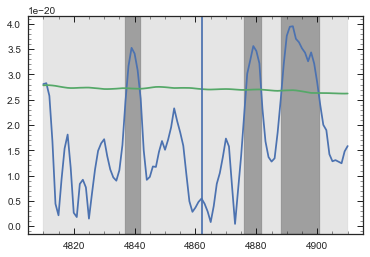

In [46]:
plt.plot(newwave,np.abs(stack))
plt.plot(newwave,err)
plt.axvline(4862)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(4837, 4842, color='k', alpha=.3)
plt.axvspan(4876, 4882, color='k', alpha=.3)
plt.axvspan(4888, 4901, color='k', alpha=.3)

